# final project code

## outline of paper

1. introduction
    1. social distancing
    2. SIR model
    3. game theory to capture how individuals react. differential game has the benefit of being continuous through time, so a player always employed a strategy and that strategy can change. 
2. model based off of reluga
    1. $c_s$ and $\bar{c_s}$ are the individual costs (that reflect a certain strategy)
    2. $\sigma(c_s)$ relays the relative risk of infection for a given $c_s$. $\sigma(c_s) \in (0, 1]$, where $\sigma(0) = 1$ because no investment in social distancing would mean the maximum risk of infection
    3. note that although an individual invests $c_s$ into their social distance strategy, the relative risk of infection is more heavily contingent on the aggregate population investment in social distancing -- $\sigma(\bar{c_s})$.
    4. 3 different states for an individual to be in, using the SIR model. SIR model has important parameters, $\beta$, $\gamma$, $\mathcal{R_0}$.
    5. system without dimensions, to be in terms of critical population sizes, cost of infection per day, ...
    6. social distancing game $\dot{p}(t) = Q(t, c)p$, where $Q(t,c)$ is a transition rate matrix between the states S, I, R. value of the game given by $\dot(-V) = (Q^T - h\mathbb{I})V + v$ because of markov process
    7. value of each state SIR by plugging in Q^T and v
    8. boundary conditions: $S(0) = R_0 - I_0$, $I(0) = I_0$, $Vs(t_f) = 0$. Vs(0) is the total cost of epidemic to an individual
    9. finding nash and sub game nash equilibrium
3. results


## the reduced system that we are solving is:


\begin{align*}
\frac {dS}{dt} &= -\sigma(\bar{c})IS \\ 
\frac {dI}{dt} &= \sigma(\bar{c})IS - I \\
-\frac {dV_s}{dt} &= -(1+V_s)\sigma(c)I - c
\end{align*}

with boundary conditions

$$ S(0) = \mathcal{R_0} - I_0, I(0) = I_0, V_s(t_f) = 0 $$

The risk of infection function $\sigma(c)$ is given by $\sigma(c) = \frac {1}{1 + mc}$, where $m$ is the maximum efficiency of social distancing. (This functional form of relative risk has several advantages..)

The social distancing cost $c$ is the same as the *strategy* of the game. Solving that system involves finding the equilibrium strategy $c^*$ which applies at both the individual and aggregate level. The best strategy can be thought of as -- regardless of what other players decided to adopt, the equilibrium strategy still maximizes the value of the game. (This is true even when players decide to adopt that equilibrium strategy itself). 

So, we want to find  $c^*$ such that for all alternative $c$, $V_s(0; c, c^*) \leq V_s(0; c^*, c^*)$. The equilibrium strategy $c^*$ is found by evaluating the payoff of the strategy (denoted by the value of the susceptible state).

Representing the equilibrium strategy implicitly, as $c = c(V_s,I)$ denoting the strategy/investment per transmission generation when the system is at $(V_s, I)$, $c^*(V_s, I) = ...

In my code,

$y(t) = \left( \begin{array}{ccc} S(t) \\ I(t) \\ -V_s(t) \end{array} \right)$

$\dot{y}(t) = \left( \begin{array} -\sigma(\bar{c})IS \\ \sigma(\bar{c})IS - I \\ -(1+V_s)\sigma(c)I- c \end{array} \right)$

In [31]:
from scipy import optimize, integrate
import numpy as np
import matplotlib.pyplot as plt

# fixed_time_plot function

here, I set up the boundary value problem

To use scipy's solve_bvp, I define two functions. The first one is an implementation of the system of ODE as listed out in 12: it takes as input time t and estimates of y. Because there are three equations in our system, y is a 3-by-n matrix; when using solve_bvp in the next section, I specify the purpose of this n. The second function is a boundary condition function that takes as input two vectors, one that contains the values of the dependent variable y at t = 0, the other at t = f. This residual function returns three values that should be zero.

Next, I turn to solve_bvp to generation my solution for this system! 

In this use of solve_BVP, I use four arguments: the two functions defined above, a 1x5 array of evenly spaced out time intervals, and y, a 3x5 array that has corresponding estimates of Y for each of the time intervals in t. My initial guess for y is arbitrary and is all one's. 

In [412]:
def fixed_time_plot(m, rknot, iknot, tf, n, social_distance_bool):
    
    def f(t, y):
        
        S = y[0]
        I = y[1]
        Vs = y[2]
        
        if social_distance_bool: 
            
            risk = lambda c: 1/(1+m*c)
            drisk = lambda c: -m/(1+m*c)**2

            cstar = np.empty((1, S.size))

            for i in range(Vs.size):
                if (-1)*drisk(0)*(1 + Vs[i])*I[i] <= 1:
                    cstar[0][i] = 0
                else: 
                    # stable version of quadratic formula to avoid catastrophic cancellation
                    cstar[0][i] = (-1 + m*I[i]*(1+Vs[i]))/(m + m*np.sqrt(m*I[i]*(1+Vs[i])))
                    # https://people.csail.mit.edu/bkph/articles/Quadratics.pdf

            dS = -risk(cstar)*I*S
            dI = risk(cstar)*I*S - I
            dVs = (1 + Vs)*risk(cstar)*I + cstar

            return np.vstack((dS, dI, -1*dVs)) 
        
        # remove the game analysis with c if no social distancing
        # equivalent to \sigma(c) = 1 constantly
        else:
        
            dS = -I*S
            dI = I*S - I
            dVs = (1 + Vs)*I

            return np.vstack((dS, dI, -1*dVs)) 
            

    def bcf(y0, ytf):
        # y0 is y(0), ytf is y(tf)

        # return 3 values that should be 0
        # S(0) - rknot, I(0) - iknot, and Vs(tf) = 0
        
        return np.array([y0[0] - rknot, y0[1] - iknot, ytf[2]])
        
    t = np.linspace(0, tf, 5)

    # initial guess of y = [[S(t)], [I(t)], [Vs(t)]]
    y = np.ones((3, 5))
    y[2] = 0

    res = integrate.solve_bvp(f, bcf, t, y)
    
    t_plot = np.linspace(0, tf, n)
    y_plot = res.sol(t_plot)
    
    return np.concatenate((np.array([t_plot]), y_plot), axis = 0)
    

# find_cstar

this function takes what is returned by fixed_time_plot to implicitly calculate cstar (based on $V_S$ and $I$)

In [290]:
def find_cstar(m, coord):
    """
    use equation 14 (in reluga 2010) and the results of fixed_time_plot to
    find the optimal social distance strategy, cstar, for each point in time
    
    parameters:
    - m is the maximum social distancing efficiency
    - coord is an array of length four that is returned from fixed_time_plot
        that has the numeric values for t, S, I, and Vs, respectively.
        
        each subarray is length n, n being the parameter for fixed_time_plot
        for the number of intervals used for solve_bvp
        
    return a size 1 array that has the values of cstar at each point in time
    """

    i_plot = coord[2]
    vs_plot = coord[3]
    n = len(i_plot)

    risk = lambda c: 1/(1+m*c)
    drisk = lambda c: -m/(1+m*c)**2

    cstar = np.empty((1, n))

    for i in range(n):
        if (-1)*drisk(0)*(1 + vs_plot[i])*i_plot[i] <= 1:
            cstar[0][i] = 0
        else:
            cstar[0][i] = (-1 + m*i_plot[i]*(1+vs_plot[i]))/(m + m*np.sqrt(m*i_plot[i]*(1+vs_plot[i])))

    return(cstar)

In [265]:
# globally define the risk function (sigma(c)) for convenience
risk_m20 = lambda c: 1/(1+20*c)

In [409]:
# understand the structure of what is returned by fixed_time_plot: 4 x n array

fixed_time_plot(1, 3, -3*10**(-6), 6, 100, True)

array([[ 0.00000000e+00,  6.06060606e-02,  1.21212121e-01,
         1.81818182e-01,  2.42424242e-01,  3.03030303e-01,
         3.63636364e-01,  4.24242424e-01,  4.84848485e-01,
         5.45454545e-01,  6.06060606e-01,  6.66666667e-01,
         7.27272727e-01,  7.87878788e-01,  8.48484848e-01,
         9.09090909e-01,  9.69696970e-01,  1.03030303e+00,
         1.09090909e+00,  1.15151515e+00,  1.21212121e+00,
         1.27272727e+00,  1.33333333e+00,  1.39393939e+00,
         1.45454545e+00,  1.51515152e+00,  1.57575758e+00,
         1.63636364e+00,  1.69696970e+00,  1.75757576e+00,
         1.81818182e+00,  1.87878788e+00,  1.93939394e+00,
         2.00000000e+00,  2.06060606e+00,  2.12121212e+00,
         2.18181818e+00,  2.24242424e+00,  2.30303030e+00,
         2.36363636e+00,  2.42424242e+00,  2.48484848e+00,
         2.54545455e+00,  2.60606061e+00,  2.66666667e+00,
         2.72727273e+00,  2.78787879e+00,  2.84848485e+00,
         2.90909091e+00,  2.96969697e+00,  3.03030303e+0

# plot for $t_f$ = 8.6 and $t_f$ = 6.4

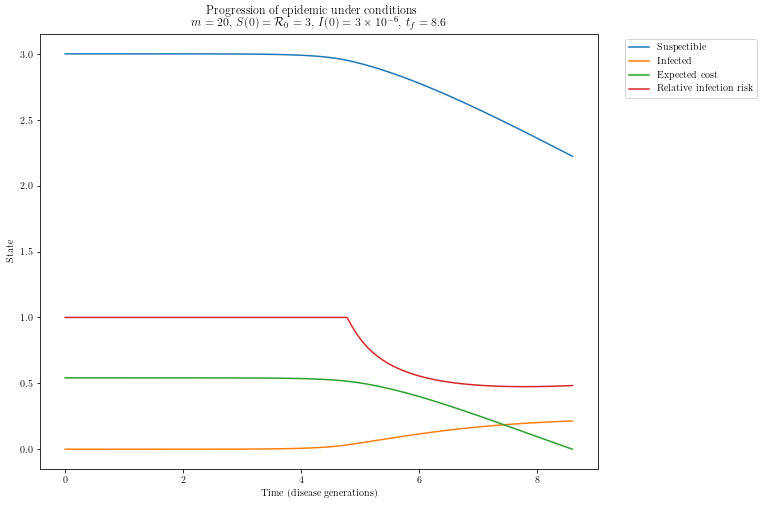

In [413]:
coord_fig5a = fixed_time_plot(20, 3, 3*10**(-6), 8.6, 100, True)
cstar_fig5a = find_cstar(20, coord_fig5a)

fig, ax = plt.subplots(figsize=(10, 8))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.plot(coord_fig5a[0], coord_fig5a[1], label = "Suspectible")
plt.plot(coord_fig5a[0], coord_fig5a[2], label = "Infected")
plt.plot(coord_fig5a[0], coord_fig5a[3], label = "Expected cost")
plt.plot(coord_fig5a[0], risk_m20(cstar_fig5a[0]), label = "Relative infection risk")

plt.legend()
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax.set(xlabel='Time (disease generations)', ylabel='State',
       title=r'Progression of epidemic under conditions \\ $m = 20$, $S(0) = \mathcal{R}_0 = 3$, $I(0) = 3 \times 10^{-6}$, $t_f = 8.6$')

plt.show()



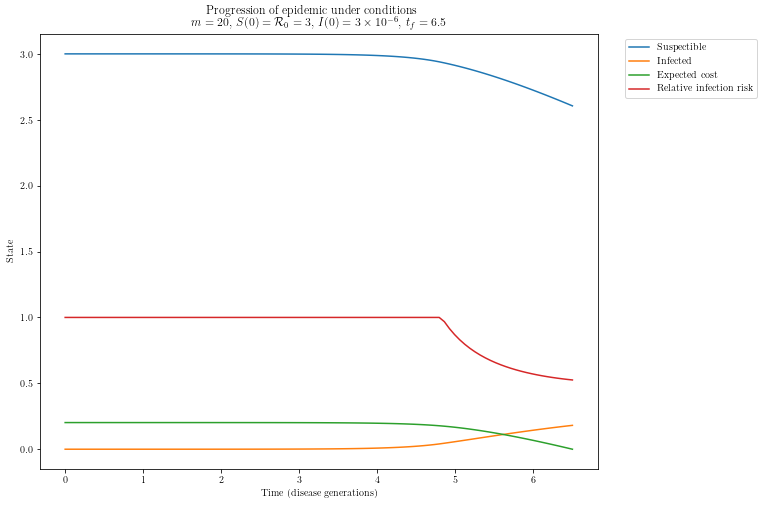

<Figure size 432x288 with 0 Axes>

In [411]:
coord_fig5b = fixed_time_plot(20, 3, 3*10**(-6), 6.5, 100, True)
cstar_fig5b = find_cstar(20, coord_fig5b)

fig, ax = plt.subplots(figsize=(10, 8))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.plot(coord_fig5b[0], coord_fig5b[1], label = "Suspectible")
plt.plot(coord_fig5b[0], coord_fig5b[2], label = "Infected")
plt.plot(coord_fig5b[0], coord_fig5b[3], label = "Expected cost")
plt.plot(coord_fig5b[0], risk_m20(cstar_fig5b[0]), label = "Relative infection risk")

plt.legend()
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax.set(xlabel='Time (disease generations)', ylabel='State',
       title=r'Progression of epidemic under conditions \\ $m = 20$, $S(0) = \mathcal{R}_0 = 3$, $I(0) = 3 \times 10^{-6}$, $t_f = 6.5$')

plt.show()

plt.savefig("figure 2")


bonus freeby when we consider social distancing vs none at all

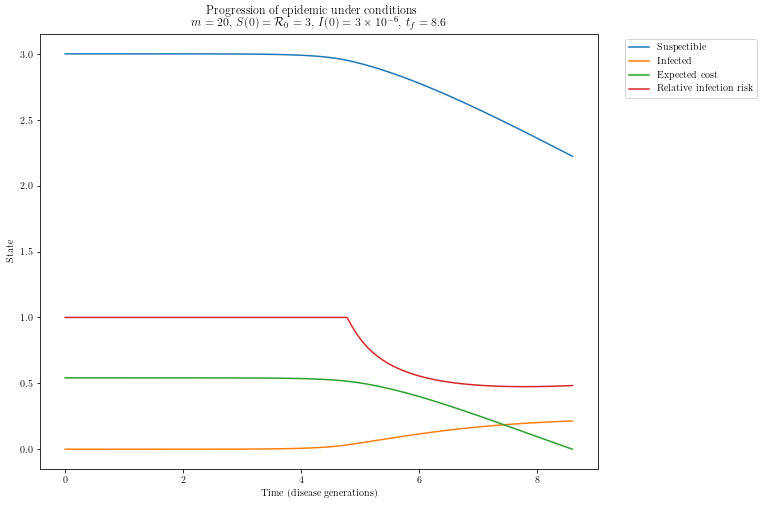

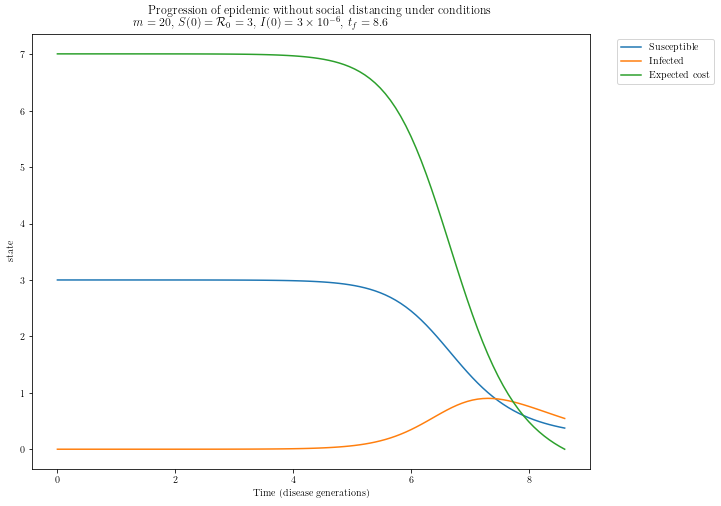

In [404]:
fig, ax = plt.subplots(figsize=(10, 8))

plt.plot(coord_fig5a[0], coord_fig5a[1], label = "Suspectible")
plt.plot(coord_fig5a[0], coord_fig5a[2], label = "Infected")
plt.plot(coord_fig5a[0], coord_fig5a[3], label = "Expected cost")
plt.plot(coord_fig5a[0], risk_m20(cstar_fig5a[0]), label = "Relative infection risk")

plt.legend()
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax.set(xlabel='Time (disease generations)', ylabel='State',
       title=r'Progression of epidemic under conditions \\ $m = 20$, $S(0) = \mathcal{R}_0 = 3$, $I(0) = 3 \times 10^{-6}$, $t_f = 8.6$')

plt.show()

coord_fig5_nodistance = fixed_time_plot(20, 3, 3*10**(-6), 8.6, 100, False)

fig, ax = plt.subplots(figsize=(10, 8))

plt.plot(coord_fig5_nodistance[0], coord_fig5_nodistance[1], label = "Susceptible")
plt.plot(coord_fig5_nodistance[0], coord_fig5_nodistance[2], label = "Infected")
plt.plot(coord_fig5_nodistance[0], coord_fig5_nodistance[3], label = "Expected cost")

plt.legend()
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax.set(xlabel='Time (disease generations)', ylabel='state',
       title=r'Progression of epidemic without social distancing under conditions \\ $m = 20$, $S(0) = \mathcal{R}_0 = 3$, $I(0) = 3 \times 10^{-6}$, $t_f = 8.6$')

plt.show()


# changing_tf

as the length of the epidemic changes, how does the trajectory of relative risk of infection change?

iterate through different values of t_f and use the first two functions, fixed_time_plot and find_cstar, to generate a giant array 

In [127]:
def changing_tf(m, rknot, iknot, tf_a, tf_b, time_step, n):
    
    tf_range = np.linspace(tf_a, tf_b, time_step)
    
    epidemic_coord = np.empty((time_step, 6, n))
    
    for i in range(tf_range.size):
        
        tf = tf_range[i]
        
        tf_label = tf*np.ones((1, n))
        tf_coord = fixed_time_plot(m, rknot, iknot, tf, n, True)
        cstar_coord = find_cstar(m, tf_coord)
        
        epidemic_coord[i] = np.concatenate((tf_label, tf_coord, cstar_coord))
        
    return(epidemic_coord)

In [343]:
coord_tf_10_34 = changing_tf(20, 3, .3*10**(-6), 10, 34, 5, 100)

# coord_tf_10_34 is a 5 x 6 x n=100 array

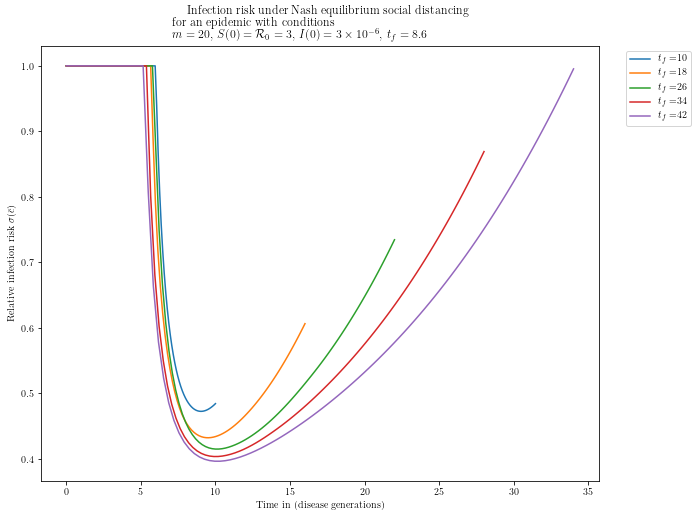

In [344]:
fig, ax = plt.subplots(figsize=(10, 8))

for i in range(len(coord_tf_10_34)):
    
    tf = 10 + 8*i
    plt.plot(coord_tf_10_34[i][1], risk_m20(coord_tf_10_34[i][5]), label = r"$t_f = $" + str(tf))
    
plt.legend()
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax.set(xlabel='Time in (disease generations)', ylabel= r'Relative infection risk $\sigma(\bar{c})$',
       title=r'Infection risk under Nash equilibrium social distancing \\ for an epidemic with conditions \\ $m = 20$, $S(0) = \mathcal{R}_0 = 3$, $I(0) = 3 \times 10^{-6}$, $t_f = 8.6$')


plt.show()

plt.savefig("figure 4")

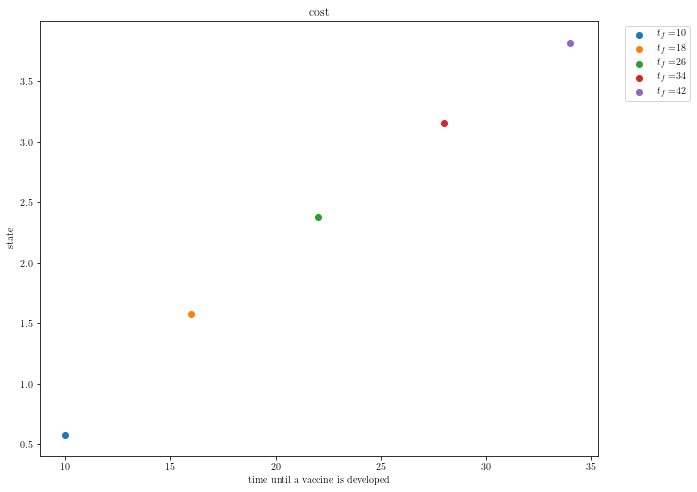

In [348]:
# cost of epidemic to an individual as tf changes -- this plot motivates the next function and plot
fig, ax = plt.subplots(figsize=(10, 8))

for i in range(len(coord_tf_10_34)):
    
    tf = 10 + 8*i
    ax.scatter(coord_tf_10_34[i][0][3], coord_tf_10_34[i][4][0], label = r"$t_f = $" + str(tf))

plt.legend()
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax.set(xlabel='time until a vaccine is developed', ylabel='state',
       title='cost')

plt.show()

# Vs_changing_m function

we have $t_f$ varying, but what about $m$ changing as well? this function builds off of changing_tf to iterate through different values of m. the returned array is simplified, though, to only include the values of $V_S(0) for epidemic length $t_f$ and social distancing efficiency $m$.

In [351]:
def Vs_changing_m(m_a, m_b, m_step, rknot, iknot, tf_a, tf_b, time_step, n):
    
    m_range = np.linspace(m_a, m_b, m_step)
    
    coord_mtVs = np.empty((m_range.size, 3, time_step))
    
    for i in range(m_range.size):
        
        m = m_range[i]
        
        epidemic_coord = changing_tf(m, rknot, iknot, tf_a, tf_b, time_step, n)
        
        Vs_knot = np.empty((1, time_step))
        
        for j in range(time_step):
            Vs_knot[0][j] = epidemic_coord[j][4][0]
            
        coord_mtVs[i][0] = m*np.ones((1, time_step))
        coord_mtVs[i][1] = np.linspace(tf_a, tf_b, time_step)
        coord_mtVs[i][2] = Vs_knot
    
    return(coord_mtVs)
        

In [349]:
coord_m_0_100 = Vs_changing_m(0, 100, 5, 3, .3*10**(-6), 10, 34, 5, 100)

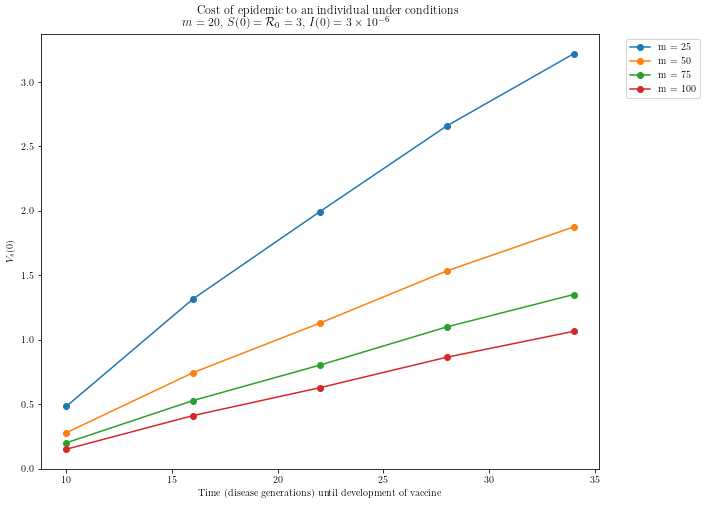

In [366]:
fig, ax = plt.subplots(figsize=(10, 8))

# ignore when m = 0 because weird values
for i in range(len(coord_m_0_100)-1):
    
    m = 25*(i+1)
    ax.plot(coord_m_0_100[i+1][1], coord_m_0_100[i+1][2], marker = 'o', linestyle='solid', label = "m = " + str(m))

plt.legend()
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.xlabel('Time (disease generations) until development of vaccine')
plt.ylabel('$V_s(0)$')
plt.title(r'Cost of epidemic to an individual under conditions \\ $m = 20$, $S(0) = \mathcal{R}_0 = 3$, $I(0) = 3 \times 10^{-6}$')

plt.show()

plt.savefig("figure 5")


# examples of finite blow up and/or catastrophic cancellation?

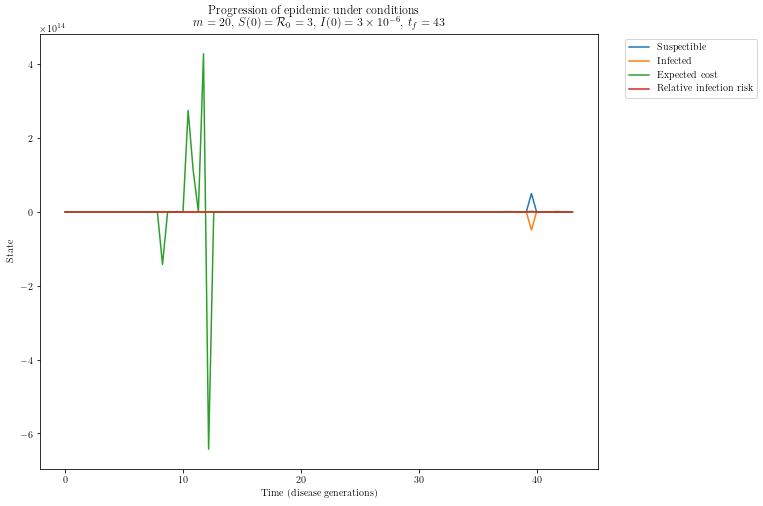

In [371]:
bad_coord = fixed_time_plot(20, 3, 3*10**(-6), 43, 100, True)
cstar_bad_coord = find_cstar(20, bad_coord)

fig, ax = plt.subplots(figsize=(10, 8))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.plot(bad_coord[0], bad_coord[1], label = "Suspectible")
plt.plot(bad_coord[0], bad_coord[2], label = "Infected")
plt.plot(bad_coord[0], bad_coord[3], label = "Expected cost")
plt.plot(bad_coord[0], risk_m20(cstar_bad_coord[0]), label = "Relative infection risk")

plt.legend()
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax.set(xlabel='Time (disease generations)', ylabel='State',
       title=r'Progression of epidemic under conditions \\ $m = 20$, $S(0) = \mathcal{R}_0 = 3$, $I(0) = 3 \times 10^{-6}$, $t_f = 43$')

plt.show()

plt.savefig("figure 6")


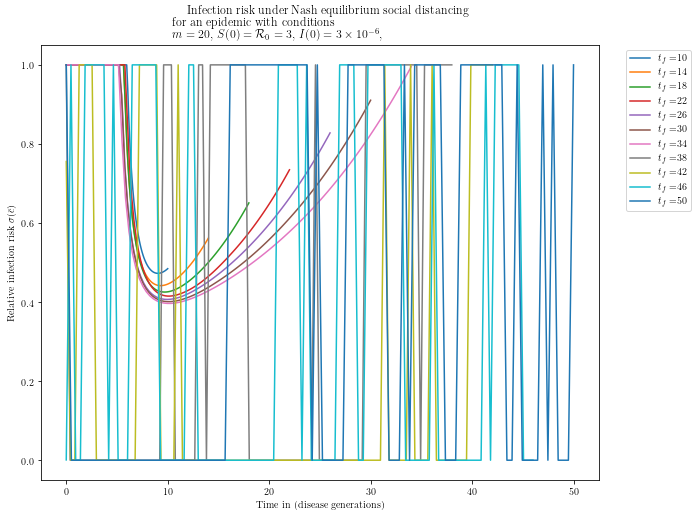

In [387]:
coord_tf_10_50 = changing_tf(20, 3, .3*10**(-6), 10, 50, 11, 100)

fig, ax = plt.subplots(figsize=(10, 8))

for i in range(len(coord_tf_10_50)):
    
    tf = 10 + 4*i
    plt.plot(coord_tf_10_50[i][1], risk_m20(coord_tf_10_50[i][5]), label = r"$t_f = $" + str(tf))
    
plt.legend()
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax.set(xlabel='Time in (disease generations)', ylabel= r'Relative infection risk $\sigma(\bar{c})$',
       title=r'Infection risk under Nash equilibrium social distancing \\ for an epidemic with conditions \\ $m = 20$, $S(0) = \mathcal{R}_0 = 3$, $I(0) = 3 \times 10^{-6}$,')


plt.show()

plt.savefig("figure 7")



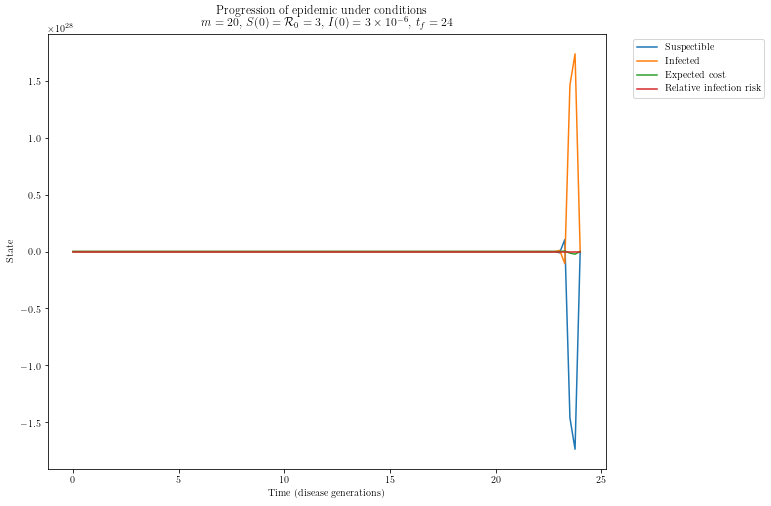

<Figure size 432x288 with 0 Axes>

In [405]:
bad_coord2 = fixed_time_plot(20, 3, 3*10**(-6), 24, 100, True)
cstar_bad_coord2 = find_cstar(20, bad_coord2)

fig, ax = plt.subplots(figsize=(10, 8))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.plot(bad_coord2[0], bad_coord2[1], label = "Suspectible")
plt.plot(bad_coord2[0], bad_coord2[2], label = "Infected")
plt.plot(bad_coord2[0], bad_coord2[3], label = "Expected cost")
plt.plot(bad_coord2[0], risk_m20(cstar_bad_coord2[0]), label = "Relative infection risk")

plt.legend()
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax.set(xlabel='Time (disease generations)', ylabel='State',
       title=r'Progression of epidemic under conditions \\ $m = 20$, $S(0) = \mathcal{R}_0 = 3$, $I(0) = 3 \times 10^{-6}$, $t_f = 24$')

plt.show()

plt.savefig("figure 8")

# bratu's example to understand bc

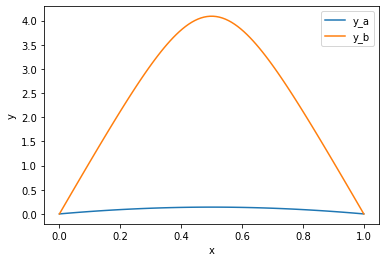

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

In [134]:
def bfun(x, y):
    # print("this x")
    # print(x)
    # print("this y")
    # print(y)
    # print("bfun returns")
    # print( np.vstack((y[1], -np.exp(y[0]))) )
    return np.vstack((y[1], -np.exp(y[0])))

def bc(ya, yb):
    # print(np.array([ya[0], yb[0]]))
    return np.array([ya[0], yb[0]])

x = np.linspace(0, 1, 5)

#two different initial guesses for y. We denote them by subscripts a and b.
y_a = np.zeros((2, x.size))
y_b = np.zeros((2, x.size))
y_b[0] = 3


res_a = integrate.solve_bvp(bfun, bc, x, y_a)
res_b = integrate.solve_bvp(bfun, bc, x, y_b)

x_plot = np.linspace(0, 1, 100)
y_plot_a = res_a.sol(x_plot)[0]
y_plot_b = res_b.sol(x_plot)[0]

plt.plot(x_plot, y_plot_a, label='y_a')
plt.plot(x_plot, y_plot_b, label='y_b')
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

print(x_plot)

old code :)))


def f(t, y):
    
    m = 20 # manually set m b/c if included as parameter, solve_bvp will try to estimate
    
    risk = lambda c: 1/(1+m*c)
    drisk = lambda c: -m/(1+m*c)**2
    
    S = y[0]
    I = y[1]
    Vs = y[2]
    
    cstar = np.empty((1, S.size))
    
    for i in range(Vs.size):
        if drisk(0)*(1 + Vs[i])*I[i]*(-1) <= 1:
            cstar[0][i] = 0
        else: 
            cstar[0][i] = optimize.brentq(lambda c: m/(1+m*c)**2*(1+Vs[i])*I[i] - 1, 0, 1)
            
    # print(cstar)
    
    dS = -risk(cstar)*I*S
    dI = risk(cstar)*I*S - I
    dVs = (1 + Vs)*risk(cstar)*I - cstar
    
    return np.vstack((dS, dI, -1*dVs)) # should it return -dVs or dVs

def bcf(y0, ytf):
    # y0 is y(0), ytf is y(tf)
    
    rknot = 3
    iknot = 3*10**(-6)
    
    # return 3 values that should be 0
    # S(0) - rknot, I(0) - iknot, and Vs(tf) = 0
    
    return np.array([y0[0] - rknot, y0[1] - iknot, ytf[2]])
    
    
t = np.linspace(0, tf, 5)

'# initial guess of y = [[S(t)], [I(t)], [Vs(t)]]
y = np.ones((3, 5))

res = integrate.solve_bvp(f, bcf, t, y)

t_plot = np.linspace(0, tf, 100)
y_plot = res.sol(t_plot)

fig, ax = plt.subplots(figsize=(5, 4))

plt.plot(t_plot, y_plot[0], label = "suspectible")
plt.plot(t_plot, y_plot[1], label = "infected")
plt.plot(t_plot, y_plot[2], label = "future cost")
plt.legend()
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax.set(xlabel='time (disease generations)', ylabel='state',
       title='solution when vaccine becomes available in fixed time')
plt.xlabel("time")
plt.ylabel("state")
plt.show()

print(t_plot)
print(y_plot)
np.concatenate((np.array([t_plot]), y_plot), axis = 0)


def contour_plot(m, rknot, iknot, tf, n, risk):
    # contour_levels is a single number
    
    # use closure/factory 
    
    def f(t, y, relative_risk):
        
        def g(t, y):

            S = y[0]
            I = y[1]
            Vs = y[2]
            
            dS = -relative_risk*I*S
            dI = relative_risk*I*S - I
            dVs = (1 + Vs)*relative_risk*I - (1/relative_risk - 1)/m

            return np.vstack((dS, dI, -1*dVs)) # should it return -dVs or dVs
        
        return g
        
        
    def bcf(y0, ytf):
        # y0 is y(0), ytf is y(tf)

        # return 3 values that should be 0
        # S(0) - rknot, I(0) - iknot, and Vs(tf) = 0
        
        return np.array([y0[0] - rknot, y0[1] - iknot, ytf[2]])
        
            
    t = np.linspace(0, tf, 5)

    # initial guess of y = [[S(t)], [I(t)], [Vs(t)]]
    y = np.ones((3, 5))
    
    res = integrate.solve_bvp(f(t, y, risk), bcf, t, y)
        
    t_plot = np.linspace(0, tf, n)
    y_plot = res.sol(t_plot)
    risk_plot = risk*np.ones((1, n))
        
    risk_coord = np.vstack((risk_plot, np.array([t_plot]), y_plot))

    return coordinate
    